In [90]:
from Algorithms.clarke_wright import ClarkeWright
from Algorithms.client import Client
from datetime import datetime, timedelta
import random
import names
import numpy as np
import matplotlib.pyplot as plt

# Generate historized client data

In [91]:
def generate_clients(start_date, end_date, min_slots, max_slots, locations, max_timeslot_picks, timeslot_usage, num_clients=1, batch_size=1):
    date_format = "%Y-%m-%d"
    start_date = datetime.strptime(start_date, date_format)
    end_date = datetime.strptime(end_date, date_format)
    date_range = (end_date - start_date).days
    
    timeslots = ['morning', 'evening']
    clients = []

    for _ in range(num_clients):
        name = names.get_full_name()  # Generating random full names
        location = random.choice(locations)
        
        while True:
            # Generate all possible availability slots within the entire date range
            possible_slots = []
            for day in (start_date + timedelta(days=i) for i in range(date_range + 1)):
                for timeslot in timeslots:
                    slot = f"{day.strftime(date_format)}_{timeslot}"
                    if timeslot_usage.get(slot, 0) < max_timeslot_picks:
                        possible_slots.append(slot)

            if len(possible_slots) < min_slots:
                return clients, f"Unable to generate"
            
            random.shuffle(possible_slots)
            availability = possible_slots[:max_slots]

            # Generate appointment day that is before or on the same day as the latest timeslot in availability
            latest_slot_day = max(datetime.strptime(slot.split('_')[0], date_format) for slot in availability)
            appointment_day = start_date + timedelta(days=random.randint(0, (latest_slot_day - start_date).days))
            appointment_hour = random.randint(0, 23)
            appointment_minute = random.randint(0, 59)
            appointment_time = datetime.combine(appointment_day, datetime.min.time()) + timedelta(hours=appointment_hour, minutes=appointment_minute)
            appointment_time_str = appointment_time.strftime(f"{date_format} %H:%M:%S")

            for slot in availability:
                timeslot_usage[slot] = timeslot_usage.get(slot, 0) + 1
            
            if len(availability) >= min_slots:
                break

        client = Client(name, location, availability, appointment_time_str)
        clients.append(client)
    
    return clients, "Clients generated successfully."

# test online case

In [92]:
def get_definitive_timeslot_clarke(clients, scheduled_definitive_appointments, distance_matrix_path):
    if not isinstance(clients, list):
        clients = [clients]
    
    old_routes = []
    new_routes = []
    
    # Gather all availability slots for the batch of clients
    slots = []
    for client in clients:
        slots.extend([slot for slot in client.availability if slot in scheduled_definitive_appointments])
    
    # If there are no appointments scheduled yet in the availability slots just schedule the clients
    if not slots:
        slot = clients[0].availability[0]
        clarkewright = ClarkeWright(clients)
        clarkewright.solve(slot, distance_matrix_path)
        scheduled_definitive_appointments[slot] = [clients, clarkewright.get_solution()]
        return f"Clients have been scheduled", scheduled_definitive_appointments
    
    # If there are appointments scheduled in the availability slots, try to add the clients to the existing routes with the minimal cost
    for slot in slots:
        old_routes.append([scheduled_definitive_appointments[slot], slot])
        clients_new = scheduled_definitive_appointments[slot][0] + clients
        clarkewright_new = ClarkeWright(clients_new)
        clarkewright_new.solve(slot, distance_matrix_path)
        new_routes.append([[clients_new, clarkewright_new.get_solution()], slot])

    # Compare the costs of all routes and pick the route with the smallest delta
    min_delta = float('inf')
    best_route = None
    for old_route, new_route in zip(old_routes, new_routes):
        old_cost = old_route[0][1][1]  # Extracting the cost from the old route
        new_cost = new_route[0][1][1]  # Extracting the cost from the new route
        # convert string 1h34min to minutes
        old_cost = int(old_cost.split('h')[0])*60 + int(old_cost.split('h')[1].split('min')[0])
        new_cost = int(new_cost.split('h')[0])*60 + int(new_cost.split('h')[1].split('min')[0])
        delta = new_cost - old_cost
        if delta < min_delta:
            min_delta = delta
            best_route = new_route
    
    # Update the scheduled_definitive_appointments with the best route
    if best_route:
        slot = best_route[1]
        scheduled_definitive_appointments[slot] = [best_route[0][0], best_route[0][1]]
        return f"Clients scheduled with the minimal delta cost.", scheduled_definitive_appointments
    
    return f"No valid route found for clients", scheduled_definitive_appointments


In [93]:

config = {
    'num_clients': 200,
    'start_date': "2024-06-01",
    'end_date': "2024-07-29",
    'min_slots': 2,
    'max_slots': 2,
    'locations': ['Asten Heusden Ommel', 'Deurne Vlierden', 'Geldrop', 'Gemert Handel', 'Helmond',
                  'Helmond Brandevoort', 'Mierlo', 'Nuenen Gerwen Nederwetten', 'Someren'],
    'distance_matrix_path': "..//Data//distance_matrix.csv",
    'max_timeslot_picks': 3  # Maximum number of timeslots a single slot can be picked
}

# random seed
random.seed(42)

In [94]:
def online_use_case(config):
    scheduled_definitive_appointments = {}
    timeslot_usage = {}
    daily_travel_time = {}
    messsage_counter = {}
    
    for _ in range(config['num_clients']):
        clients, genmessage = generate_clients(config['start_date'], config['end_date'], config['min_slots'], config['max_slots'], config['locations'], config['max_timeslot_picks'], timeslot_usage, num_clients=1)
        if genmessage == "Clients generated successfully.":
            client = clients[0]
            message, scheduled_definitive_appointments = get_definitive_timeslot_clarke(client, scheduled_definitive_appointments, config['distance_matrix_path'])
            # Count the number of messages for each type
            if message in messsage_counter:
                messsage_counter[message] += 1
            else:
                messsage_counter[message] = 1
            
            # Collect travel time per day
            for slot, details in scheduled_definitive_appointments.items():
                day = slot.split('_')[0]
                # convert string 1h34min to minutes
                daily_travel_time[day] = int(details[1][1].split('h')[0])*60 + int(details[1][1].split('h')[1].split('min')[0])           
        elif genmessage == "Unable to generate":
            if str(genmessage) in messsage_counter:
                messsage_counter[str(genmessage)] += 1
            else:
                messsage_counter[str(genmessage)] = 1
        else:
            assert False, f"No message"
            
    return daily_travel_time, messsage_counter     

In [95]:
print("Online Use Case Results:")
online_data, messsage_counter = online_use_case(config)
print(f"Messages: {messsage_counter}")

Online Use Case Results:
Messages: {'Clients have been scheduled': 81, 'Clients scheduled with the minimal delta cost.': 96, 'Unable to generate': 23}


# test offline case

In [96]:
def offline_use_case(config):
    scheduled_definitive_appointments = {}
    timeslot_usage = {}
    daily_travel_time = {}

    total_clients = config['num_clients']
    batch_size = config['batch_size']
    num_batches = (total_clients + batch_size - 1) // batch_size  # Calculate the number of batches

    clients_generated = 0
    messsage_counter = {}
    for _ in range(num_batches):
        # Calculate how many clients to generate in this batch
        clients_in_batch = min(batch_size, total_clients - clients_generated)
        
        batch_clients, genmessage = generate_clients(config['start_date'], config['end_date'], config['min_slots'], config['max_slots'], config['locations'], config['max_timeslot_picks'], timeslot_usage, num_clients=clients_in_batch)
        if genmessage == "Clients generated successfully.":
            message, scheduled_definitive_appointments = get_definitive_timeslot_clarke(batch_clients, scheduled_definitive_appointments, config['distance_matrix_path'])
            # Count the number of messages for each type
            if message in messsage_counter:
                messsage_counter[message] += 1         
            else:
                messsage_counter[message] = 1
                
            # Collect travel time per day
            for slot, details in scheduled_definitive_appointments.items():
                day = slot.split('_')[0]
                travel_time = details[1][1]
                hours, minutes = map(int, travel_time.replace('h', ' ').replace('min', '').split())
                daily_travel_time[day] = hours * 60 + minutes
        elif genmessage == "Unable to generate":
            if str(genmessage) in messsage_counter:
                messsage_counter[str(genmessage)] += 1
            else:
                messsage_counter[str(genmessage)] = 1
        else:
            assert False, f"No message"
            
        clients_generated += clients_in_batch
        if clients_generated >= total_clients:
            break

    return daily_travel_time, messsage_counter


In [97]:
print("Generating Offline Use Case Data...")
batch_sizes = [2, 3, 4, 5, 10]  # Different batch sizes to test
offline_data = {}
for batch_size in batch_sizes:
    offline_config = config.copy()
    offline_config['batch_size'] = batch_size
    offline_data[batch_size], messages = offline_use_case(offline_config)
    print(f"Batch size: {batch_size}, Messages: {messages}")

Generating Offline Use Case Data...
Batch size: 2, Messages: {'Clients have been scheduled': 48, 'Clients scheduled with the minimal delta cost.': 40, 'Unable to generate': 12}
Batch size: 3, Messages: {'Clients have been scheduled': 28, 'Clients scheduled with the minimal delta cost.': 30, 'Unable to generate': 9}
Batch size: 4, Messages: {'Clients have been scheduled': 27, 'Clients scheduled with the minimal delta cost.': 17, 'Unable to generate': 6}
Batch size: 5, Messages: {'Clients have been scheduled': 19, 'Clients scheduled with the minimal delta cost.': 16, 'Unable to generate': 5}
Batch size: 10, Messages: {'Clients have been scheduled': 9, 'Clients scheduled with the minimal delta cost.': 8, 'Unable to generate': 3}


In [98]:
def plot_travel_times(online_data, offline_data, batch_sizes):
    dates = sorted(set(str(date) for date in online_data.keys()).union(set(str(date) for date in offline_data.keys())))
    online_times = [online_data.get(date, 0) for date in dates]
    offline_times = {batch_size: [offline_data[batch_size].get(date, 0) for date in dates] for batch_size in batch_sizes}

    # Plot the total travel time for each method
    plt.figure(figsize=(12, 6))
    plt.plot(dates, online_times, label='Online (one by one)')
    for batch_size in batch_sizes:
        plt.plot(dates, offline_times[batch_size], label=f'Offline (batch size: {batch_size})')
    plt.xlabel('Date')
    plt.ylabel('Total Travel Time (minutes)')
    plt.title('Total Travel Time per Day: Online vs Offline')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate and plot the cumulative travel time for each method
    plt.figure(figsize=(12, 6))
    plt.plot(dates, np.cumsum(online_times), label='Online (one by one)')
    for batch_size in batch_sizes:
        plt.plot(dates, np.cumsum(offline_times[batch_size]), label=f'Offline (batch size: {batch_size})')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Travel Time (minutes)')
    plt.title('Cumulative Travel Time over Weeks: Online vs Offline')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate and plot the average daily travel time for each method
    # but also add the days where no clients were scheduled to the average calculation
    online_avg = sum(online_times) / len(dates)
    offline_avgs = {batch_size: sum(offline_times[batch_size]) / len(dates) for batch_size in batch_sizes}
    plt.figure(figsize=(12, 6))
    plt.bar('Online', online_avg, label='Online (one by one)')
    for batch_size in batch_sizes:
        plt.bar(f'Offline (batch size: {batch_size})', offline_avgs[batch_size], label=f'Offline (batch size: {batch_size})')   
    plt.xlabel('Method')
    plt.ylabel('Average Daily Travel Time (minutes)')
    plt.title('Average Daily Travel Time: Online vs Offline')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    

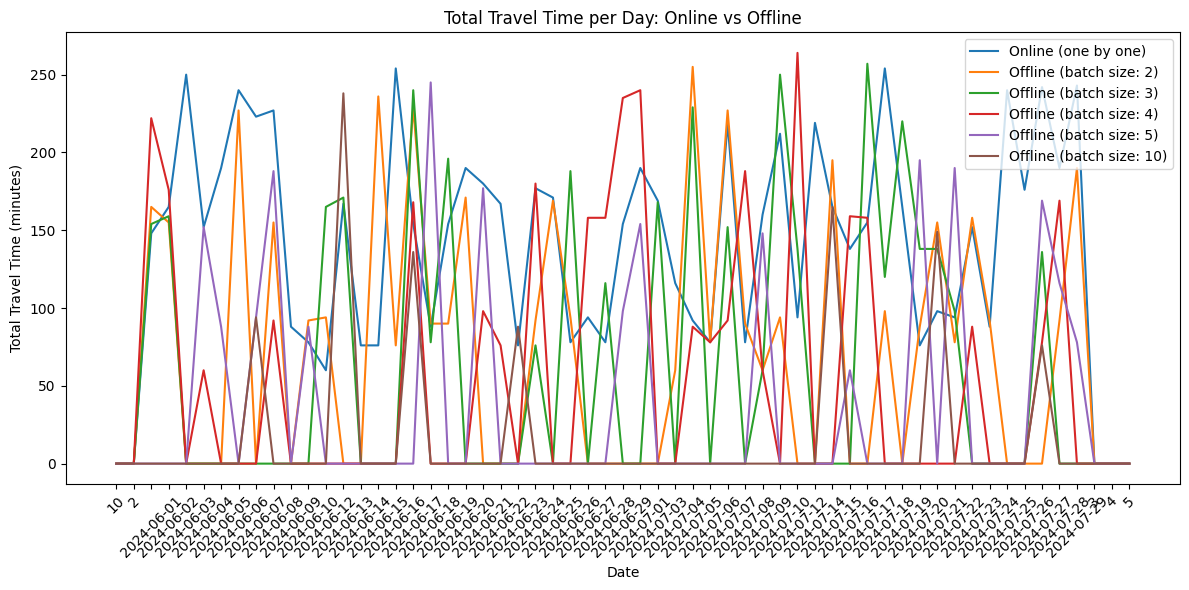

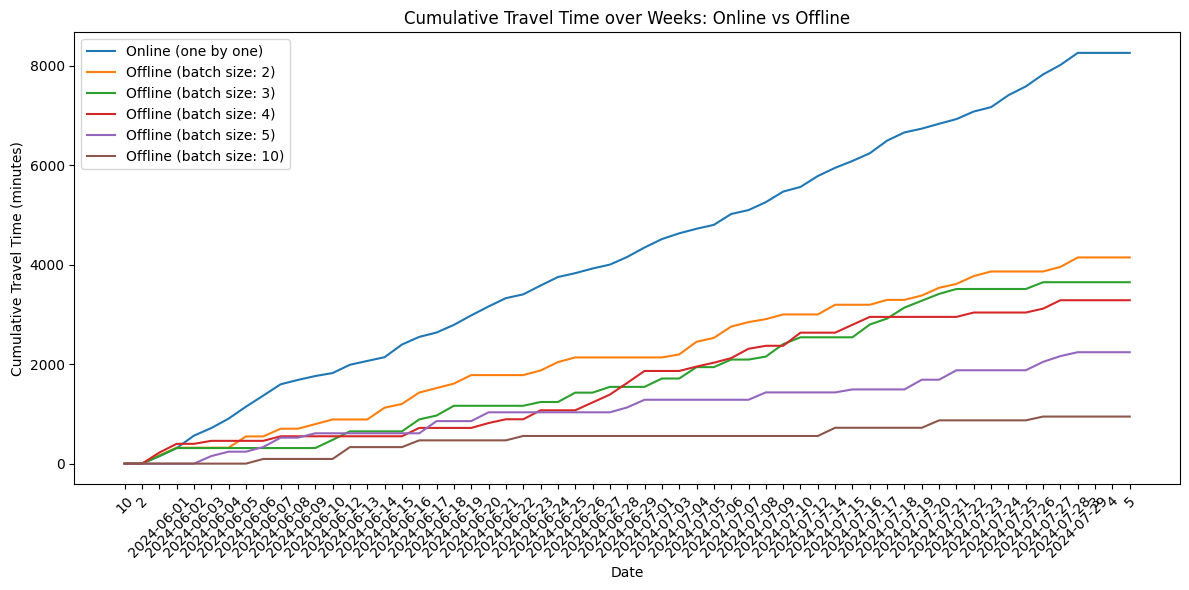

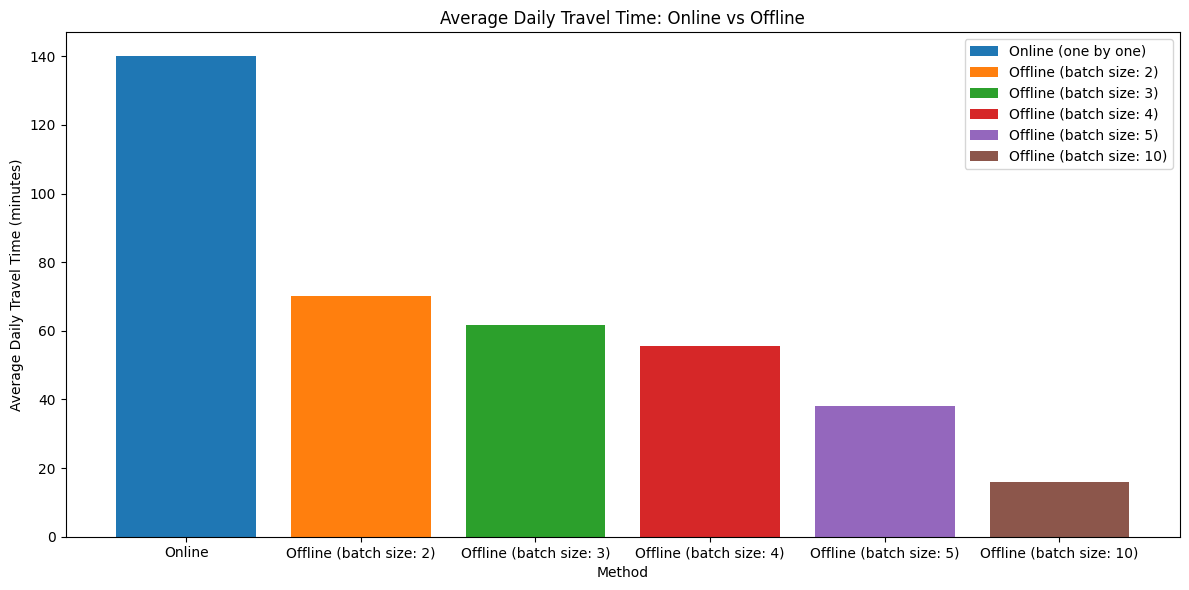

In [99]:
plot_travel_times(online_data, offline_data, batch_sizes)